In [1]:
#Yu Yamaoka
#crop段階でフォルダPathの指定が関数内部で行ってしまっている点に注意．

#Parameter Define
model_type = 'cyto'#https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L19~L20
chan = [0,0]#チャンネル https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L209

In [1]:
#Function Define
from cellpose import models, io
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
def img_to_cellpose(img_path, model_type= 'cyto', chan=[0,0], min_size=30):
    """
    Input:
        img_path : (string) Image file PATH
    Return:
        mask : [width, height]
    """
    model = models.Cellpose(gpu=False, model_type=model_type)
    img = io.imread(img_path)
    mask, flows, styles, diams = model.eval(img, diameter=None, channels=chan, min_size=min_size)

    # save results so you can load in gui
    #io.masks_flows_to_seg(img, masks, flows, diams, img_path, chan)

    # save results as png
    #plt.imsave("test.png",masks)

    return mask

#mask画像をMaskRCNNが読み込めるデータセットにする。
def obj_detection(mask, class_id:int):
    """
    Input:
        mask : [width, height](ndarray), image data
        class_id : int , class id(ex : 1day -> 1)
    Return:
        mask : [width, height, n], n is object num.
        cls_idxs : [n(int)]
    """
    data = mask
    labels = []
    for label in np.unique(data):
        #: ラベルID==0は背景
        if label == 0:
            continue
        else:
            labels.append(label)

    if len(labels) == 0:
        #: 対象オブジェクトがない場合はNone
        return None, None
    else:
        mask = np.zeros((mask.shape)+(len(labels),), dtype=np.uint8)
        for n, label in enumerate(labels):
            mask[:, :, n] = np.uint8(data == label)
        cls_idxs = np.ones([mask.shape[-1]], dtype=np.int32) * class_id

        return mask, cls_idxs

def mask_to_patch(masks, img_path, size=64):
    """
    Input:
        masks : [n(objnum), width, height], n is object num.
        img_path : original image path of mask
    Return:
        crop_imgs :  [n(objnum), width, height, color]
    """
    #各mask-objのBBOXの重心点を求めて切り抜き
    img = cv2.imread(img_path)
    width, height, _ = img.shape
    crop_imgs = np.zeros((size, size, 3)+(len(masks),), dtype=np.uint8)
    
    #1オブジェクトごとにcropをする
    for i in range(len(masks)):
        #重心計算
        mu = cv2.moments(masks[i], False)
        g_height, g_width = int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
        
        height_min = g_height - size//2
        height_max = g_height + size//2
        width_min = g_width - size//2
        width_max = g_width + size//2
        
        #壁際の例外処理
        if height_min<0:#配列外アクセスを防ぐ
            height_min = 0
            height_max= (size//2) * 2
        elif height_max>height:#配列外アクセスを防ぐ
            height_min = height - ((size//2)  * 2 + 1)
            height_max = height - 1
    
        #壁際の例外処理
        if width_min<0:#配列外アクセスを防ぐ
            width_min = 0
            width_max= (size//2) * 2
        elif width_max>width:#配列外アクセスを防ぐ
            width_min = width - ((size//2)  * 2 + 1)
            width_max = width - 1
        
        crop_imgs[:, :, :, i] = img[width_min:width_max, height_min:height_max]

    crop_imgs = crop_imgs.transpose(3, 0 , 1, 2)
    return crop_imgs
   

In [3]:
#main
from glob import glob
from tqdm import tqdm

days = ["0", "3", "5", "7"]
size = 64

for day in days:
    files = glob("../data/cut_patch512512/"+str(day)+"day/*.png")
    for file in tqdm(files):
        try:
            test_path = file
            mask = img_to_cellpose(test_path, model_type, chan)
            mask, _ = obj_detection(mask, 1)
            mask_trans = mask.transpose(2, 0 ,1)
            crop_imgs = mask_to_patch(mask_trans, test_path, size=64)
            
            #save
            for i, crop_img in enumerate(crop_imgs):
            
                filename  = os.path.basename(file)
                if(os.path.exists('crop_test_data'+str(size)+'/image/day' +str(day))==False):
                    os.mkdir('crop_test_data'+str(size)+'/image/day' +str(day))
                save_path = os.path.join('crop_test_data'+str(size)+'/image/day' +str(day), str(i) + "_" + filename)
                cv2.imwrite(save_path, crop_img)
        except:
            print(file)


  1%|▏         | 2/155 [00:07<09:57,  3.90s/it]

../data/cut_patch512512/0day/3No2(L) ctx0day.tif.png_change.pngcolor_change.png


  3%|▎         | 4/155 [00:14<09:08,  3.63s/it]

デバッグテスト

In [37]:
def mask_to_mask(masks, mask, size=64):
    """
    Input:
        masks : [n(objnum), width, height], n is object num.
        img_path : original image path of mask
    Return:
        crop_imgs :  [n(objnum), width, height, color]
    """
    #各mask-objのBBOXの重心点を求めて切り抜き
    img = mask
    width, height = img.shape
    crop_imgs = np.zeros((size, size, 3)+(len(masks),), dtype=np.uint8)
    
    #1オブジェクトごとにcropをする
    for i in range(len(masks)):
        #重心計算
        mu = cv2.moments(masks[i], False)
        g_height, g_width = int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
        
        height_min = g_height - size//2
        height_max = g_height + size//2
        width_min = g_width - size//2
        width_max = g_width + size//2
        
        #壁際の例外処理
        if height_min<0:#配列外アクセスを防ぐ
            height_min = 0
            height_max= (size//2) * 2
        elif height_max>height:#配列外アクセスを防ぐ
            height_min = height - ((size//2)  * 2 + 1)
            height_max = height - 1

        #壁際の例外処理
        if width_min<0:#配列外アクセスを防ぐ
            width_min = 0
            width_max= (size//2) * 2
        elif width_max>width:#配列外アクセスを防ぐ
            width_min = width - ((size//2)  * 2 + 1)
            width_max = width - 1
            
            crop_imgs[:, :, i] = img[width_min:width_max, height_min:height_max]

        crop_imgs = crop_imgs.transpose(3, 0 , 1, 2)
        import matplotlib.pyplot as plt
        plt.matshow(mask)
        plt.matshow(masks[i])
        plt.matshow(img[width_min:width_max, height_min:height_max])
    
    return crop_imgs



In [38]:

mask = img_to_cellpose("4No2(L) ctx0day.tif.png_change.pngcolor_change.png", model_type, chan)
masks, _ = obj_detection(mask, 1)
print(masks.shape)
mask_trans = masks.transpose(2, 0 ,1)


(512, 512, 12)


ValueError: could not broadcast input array from shape (64,64) into shape (3,12,64)

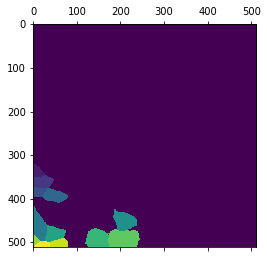

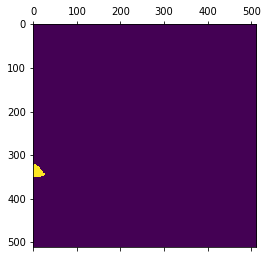

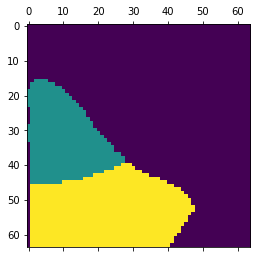

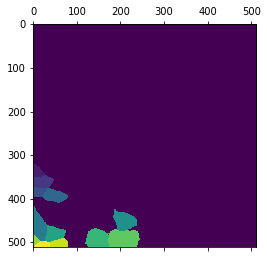

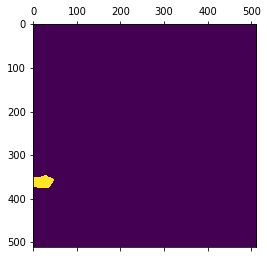

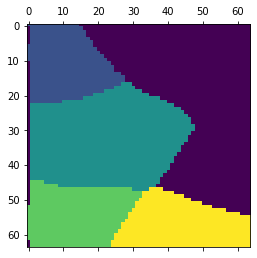

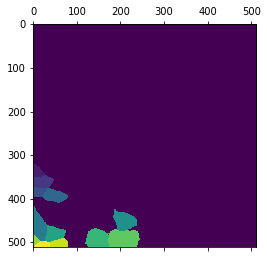

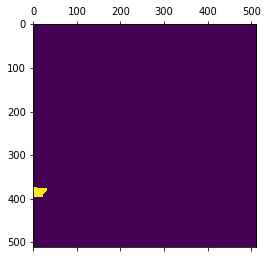

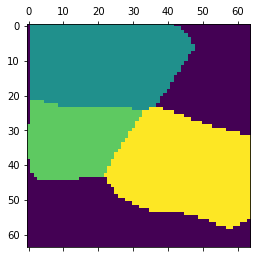

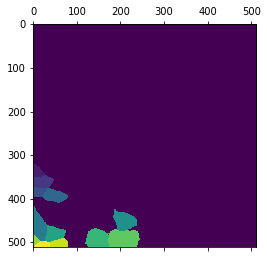

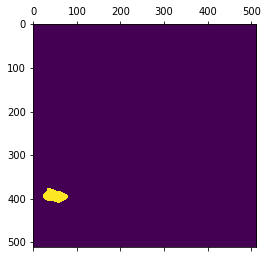

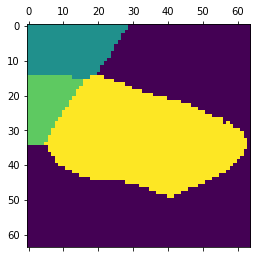

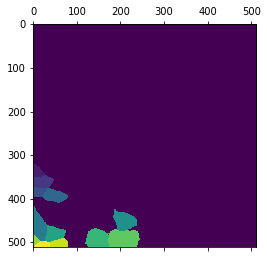

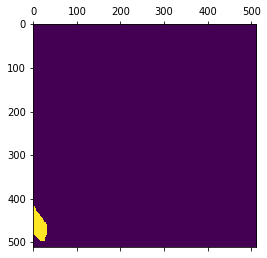

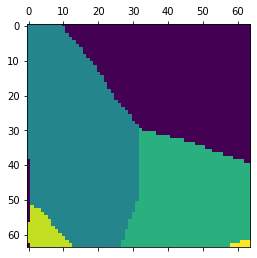

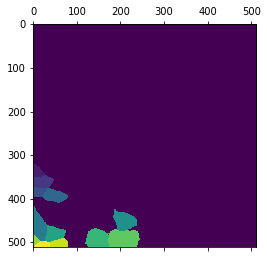

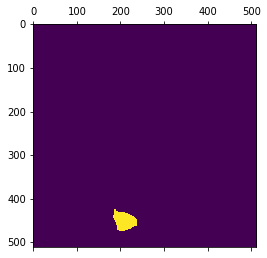

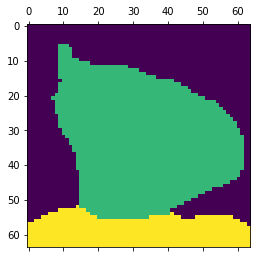

In [39]:
crop_imgs = mask_to_mask(mask_trans, mask, size=64)